<a href="https://colab.research.google.com/github/VicenteFran19/analisis_store-sales-time-series-forecasting/blob/main/Analisis-Regresion-v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importando Libreria

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import plotly.express as px
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

Importando datos

In [ ]:
try:
    del train
except NameError:
    train = None

In [ ]:
train = pd.read_csv('train.csv',sep=',')
train.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion'], dtype='object')

In [ ]:
len(train['id'])

3000888

In [ ]:
test = pd.read_csv('test.csv',sep=',')
test.columns

Index(['id', 'date', 'store_nbr', 'family', 'onpromotion'], dtype='object')

In [ ]:
oil = pd.read_csv('oil.csv',sep=',')
oil.columns

Index(['date', 'dcoilwtico'], dtype='object')

In [ ]:
sample_submission = pd.read_csv('sample_submission.csv',sep=',')
sample_submission.columns

Index(['id', 'sales'], dtype='object')

In [ ]:
stores = pd.read_csv('stores.csv',sep=',')
stores.columns

Index(['store_nbr', 'city', 'state', 'type', 'cluster'], dtype='object')

In [ ]:
transactions = pd.read_csv('transactions.csv',sep=',')
transactions.columns

Index(['date', 'store_nbr', 'transactions'], dtype='object')

In [ ]:
holidays_events = pd.read_csv('holidays_events.csv',sep=',')
holidays_events.columns

Index(['date', 'type', 'locale', 'locale_name', 'description', 'transferred'], dtype='object')

In [ ]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [ ]:
# Busca duplicados en una columna especifica
train[train.duplicated(subset='id')]

,id,date,store_nbr,family,sales,onpromotion


In [ ]:
# Ordenando el tipo de las variables
print(train.dtypes)

id               int64
date            object
store_nbr        int64
family          object
sales          float64
onpromotion      int64
dtype: object


In [ ]:
train['onpromotion'] = train['onpromotion'].astype(int)
train['store_nbr'] = train['store_nbr'].astype(int)

In [ ]:
# Insertando la data de stores
df_1 = pd.merge(train, stores, on='store_nbr')

In [ ]:
df_2 = pd.merge(df_1, oil, on='date', how = 'left')

In [ ]:
# El ultimo registro es en la fecha 2017-08-15
df_2.tail()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,Quito,Pichincha,B,6,47.57
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Quito,Pichincha,B,6,47.57
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,Quito,Pichincha,B,6,47.57
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Quito,Pichincha,B,6,47.57
3000887,3000887,2017-08-15,9,SEAFOOD,16.000,0,Quito,Pichincha,B,6,47.57


In [ ]:
# El primer registro es en la fecha 2013-01-01
df_2.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN


In [ ]:
# Solo quiero fechas de eventos que coincidan con las fechas del dataset anterior
# Se debe solo tener fechas festivas despues de 2012-12-31 y antes del 2017-08-16
holidays_events.tail()

,date,type,locale,locale_name,description,transferred
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False
349,2017-12-26,Additional,National,Ecuador,Navidad+1,False


In [ ]:
holidays_events_filtrado = holidays_events[ (holidays_events['date'] > '2012-12-31') & (holidays_events['date'] < '2017-08-16')]

In [ ]:
holidays_events_filtrado.head()

,date,type,locale,locale_name,description,transferred
41,2013-01-01,Holiday,National,Ecuador,Primer dia del ano,False
42,2013-01-05,Work Day,National,Ecuador,Recupero puente Navidad,False
43,2013-01-12,Work Day,National,Ecuador,Recupero puente primer dia del ano,False
44,2013-02-11,Holiday,National,Ecuador,Carnaval,False
45,2013-02-12,Holiday,National,Ecuador,Carnaval,False


In [ ]:
df_3 = pd.merge(df_2, holidays_events_filtrado, on='date', how='left')

Exploracion de dataset

In [ ]:
df_3.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,dcoilwtico,type_y,locale,locale_name,description,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False


In [ ]:
df_3.rename(columns = { 'dcoilwtico':'precio_oil','onpromotion':'Num_articulos_promocion','type_x':'Sector', 'type_y':'Tipo_holiday'} , inplace = True)

In [ ]:
df_3.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'Num_articulos_promocion',
       'city', 'state', 'Sector', 'cluster', 'precio_oil', 'Tipo_holiday',
       'locale', 'locale_name', 'description', 'transferred'],
      dtype='object')

In [ ]:
df_3.head(3)

,id,date,store_nbr,family,sales,Num_articulos_promocion,city,state,Sector,cluster,precio_oil,Tipo_holiday,locale,locale_name,description,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False


In [ ]:
df_3[['locale','locale_name']].value_counts().sort_values()

locale    locale_name                   
Regional  Santo Domingo de los Tsachilas      7128
Local     Ibarra                              7128
          Salinas                             7128
          Loja                                7128
          Quevedo                             7128
Regional  Santa Elena                         7128
Local     El Carmen                           8910
          Esmeraldas                          8910
          Libertad                            8910
          Machala                             8910
          Cayambe                             8910
          Manta                               8910
          Santo Domingo                       8910
Regional  Imbabura                            8910
Local     Puyo                                8910
Regional  Cotopaxi                            8910
Local     Cuenca                             10692
          Quito                              14256
          Ambato                             14256
          Latacunga                          16038
          Guaranda                           16038
          Riobamba                           17820
          Guayaquil                          19602
National  Ecuador                           261954
Name: count, dtype: int64

In [ ]:
df_3[['city','state','Sector','cluster']].value_counts().sort_values()

,,,,count
city,state,Sector,cluster,
Santo Domingo,Santo Domingo de los Tsachilas,B,6,56562
Machala,El Oro,D,4,56562
Manta,Manabi,A,11,56562
Ambato,Tungurahua,D,9,56562
Babahoyo,Los Rios,B,10,56562
Cayambe,Pichincha,B,6,56562
Cuenca,Azuay,B,6,56562
Daule,Guayas,D,1,56562
El Carmen,Manabi,C,3,56562


In [ ]:
len(df_3)

3054348

In [ ]:
df_4 = df_3[['id', 'date', 'store_nbr', 'family', 'sales', 'Num_articulos_promocion','cluster', 'precio_oil', 'Tipo_holiday','locale','transferred']]

In [ ]:
(df_4.isnull().sum()/len(df_4))*100

,0
id,0.000000
date,0.000000
store_nbr,0.000000
family,0.000000
sales,0.000000
Num_articulos_promocion,0.000000
cluster,0.000000
precio_oil,31.271879
Tipo_holiday,83.547258
locale,83.547258


Valores missing

In [ ]:
# Revisando Tipo_holiday
df_4['Tipo_holiday'].value_counts(dropna = False)

,count
Tipo_holiday,
NaN,2551824
Holiday,304722
Event,99792
Additional,67716
Transfer,16038
Work Day,8910
Bridge,5346


In [ ]:
# La variable Tipo_holiday tiene estas categorias:
# Dia No Laborable: ['Holiday', 'Event', 'Additional', 'Transfer', 'Bridge']
# Dia Laborablr: [Nan , Work Day]

# Se va a cambiar de las 6 categorias a solo 2

def clasificar_dia(tipo_holiday,transferred):
    if tipo_holiday in ['Holiday', 'Event', 'Additional', 'Transfer', 'Bridge'] and not transferred:
        return 'No laborable'
    else:
        return 'Laborable'

df_4['Dia'] = df_4.apply(lambda x: clasificar_dia(x['Tipo_holiday'], x['transferred']), axis=1)

<ipython-input-87-ec6866945b29>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_4['Dia'] = df_4.apply(lambda x: clasificar_dia(x['Tipo_holiday'], x['transferred']), axis=1)


In [ ]:
# Simplificando el numero de variables
df_4 = df_4[['id','date','store_nbr','family','sales','Num_articulos_promocion','cluster','precio_oil','locale','Dia']]

In [ ]:
df_4.head()

,id,date,store_nbr,family,sales,Num_articulos_promocion,cluster,precio_oil,Tipo_holiday,locale,transferred,Dia
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,13,NaN,Holiday,National,False,No laborable
1,1,2013-01-01,1,BABY CARE,0.0,0,13,NaN,Holiday,National,False,No laborable
2,2,2013-01-01,1,BEAUTY,0.0,0,13,NaN,Holiday,National,False,No laborable
3,3,2013-01-01,1,BEVERAGES,0.0,0,13,NaN,Holiday,National,False,No laborable
4,4,2013-01-01,1,BOOKS,0.0,0,13,NaN,Holiday,National,False,No laborable


In [ ]:
(df_4.isnull().sum()/len(df_4))*100

,0
id,0.000000
date,0.000000
store_nbr,0.000000
family,0.000000
sales,0.000000
Num_articulos_promocion,0.000000
cluster,0.000000
precio_oil,31.271879
Tipo_holiday,83.547258
locale,83.547258


In [ ]:
# Simplificando las variables Locale y Dia a uno solo

def combinar_variables(row):
    if row['Dia'] == 'No laborable':
        return row['Dia'] + ' ' + row['locale']
    else:
        return 'Laborable'

df_4['Tipo_de_Dia'] = df_4.apply(combinar_variables, axis=1)



<ipython-input-90-32bbd47eb486>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_4['Tipo_de_Dia'] = df_4.apply(combinar_variables, axis=1)


In [ ]:
df_4.head()

,id,date,store_nbr,family,sales,Num_articulos_promocion,cluster,precio_oil,locale,Dia,Tipo_de_Dia
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,13,NaN,National,No laborable,No laborable National
1,1,2013-01-01,1,BABY CARE,0.0,0,13,NaN,National,No laborable,No laborable National
2,2,2013-01-01,1,BEAUTY,0.0,0,13,NaN,National,No laborable,No laborable National
3,3,2013-01-01,1,BEVERAGES,0.0,0,13,NaN,National,No laborable,No laborable National
4,4,2013-01-01,1,BOOKS,0.0,0,13,NaN,National,No laborable,No laborable National


In [ ]:
df_4 = df_4[['id',	'date'	,	'family' ,	'sales' ,	'Num_articulos_promocion' ,	'cluster' ,	'precio_oil','Tipo_de_Dia']]

In [ ]:
(df_4.isnull().sum()/len(df_4))*100

,0
id,0.000000
date,0.000000
family,0.000000
sales,0.000000
Num_articulos_promocion,0.000000
cluster,0.000000
precio_oil,31.271879
Tipo_de_Dia,0.000000


In [ ]:
df_4.head()

,id,date,family,sales,Num_articulos_promocion,cluster,precio_oil,Tipo_de_Dia
0,0,2013-01-01,AUTOMOTIVE,0.0,0,13,NaN,No laborable National
1,1,2013-01-01,BABY CARE,0.0,0,13,NaN,No laborable National
2,2,2013-01-01,BEAUTY,0.0,0,13,NaN,No laborable National
3,3,2013-01-01,BEVERAGES,0.0,0,13,NaN,No laborable National
4,4,2013-01-01,BOOKS,0.0,0,13,NaN,No laborable National


In [ ]:
df_4.columns

Index(['id', 'date', 'family', 'sales', 'Num_articulos_promocion', 'cluster',
       'precio_oil', 'Tipo_de_Dia'],
      dtype='object')

In [ ]:
# df_4['precio_oil'] tiene el 30% de registros vacios. Se eliminan esos registros para no eliminar la variable completa
df_4 = df_4[df_4['precio_oil'].notna()]

In [ ]:
df_4.head()

,id,date,family,sales,Num_articulos_promocion,cluster,precio_oil,Tipo_de_Dia
1782,1782,2013-01-02,AUTOMOTIVE,2.0,0,13,93.14,Laborable
1783,1783,2013-01-02,BABY CARE,0.0,0,13,93.14,Laborable
1784,1784,2013-01-02,BEAUTY,2.0,0,13,93.14,Laborable
1785,1785,2013-01-02,BEVERAGES,1091.0,0,13,93.14,Laborable
1786,1786,2013-01-02,BOOKS,0.0,0,13,93.14,Laborable


In [ ]:
len(df_4)

2099196

ANALISIS EXPLORATORIO DE LOS DATOS

In [ ]:
import seaborn as sns

In [ ]:
df_4['Tipo_de_Dia'].value_counts()

,count
Tipo_de_Dia,
Laborable,1790910
No laborable National,146124
No laborable Local,138996
No laborable Regional,23166


In [ ]:
df_4 = pd.get_dummies(df_4, columns=['Tipo_de_Dia'], drop_first=True)
# Convertir booleanos a enteros (0 y 1)
df_4[['Tipo_de_Dia_No laborable Local', 'Tipo_de_Dia_No laborable National', 'Tipo_de_Dia_No laborable Regional']] = \
    df_4[['Tipo_de_Dia_No laborable Local', 'Tipo_de_Dia_No laborable National', 'Tipo_de_Dia_No laborable Regional']].astype(int)


In [ ]:
df_4.head()

,id,date,family,sales,Num_articulos_promocion,cluster,precio_oil,Tipo_de_Dia_No laborable Local,Tipo_de_Dia_No laborable National,Tipo_de_Dia_No laborable Regional
1782,1782,2013-01-02,AUTOMOTIVE,2.0,0,13,93.14,0,0,0
1783,1783,2013-01-02,BABY CARE,0.0,0,13,93.14,0,0,0
1784,1784,2013-01-02,BEAUTY,2.0,0,13,93.14,0,0,0
1785,1785,2013-01-02,BEVERAGES,1091.0,0,13,93.14,0,0,0
1786,1786,2013-01-02,BOOKS,0.0,0,13,93.14,0,0,0


In [ ]:
# La variable date
# Usar year, month, y day para predecir ventas diarias exactas:


# Convertir la columna 'date' a formato datetime
df_4['date'] = pd.to_datetime(df_4['date']) # -------------------- se borra

# Extraer las variables 'year', 'month', y 'day'
df_4['year'] = df_4['date'].dt.year
df_4['month'] = df_4['date'].dt.month # ------------------------- se borra
df_4['day'] = df_4['date'].dt.day # ---------------------------  se borra


# Mes:  Es una variable periódica, por lo que se transforma en variables cíclicas para que el modelo entienda que enero (1) está cerca de diciembre (12)


# Crear variables cíclicas para 'month' y 'day'
df_4['month_sin'] = np.sin(2 * np.pi * df_4['month'] / 12)
df_4['month_cos'] = np.cos(2 * np.pi * df_4['month'] / 12)
df_4['day_sin'] = np.sin(2 * np.pi * df_4['day'] / 31)
df_4['day_cos'] = np.cos(2 * np.pi * df_4['day'] / 31)

In [ ]:
df_4.head()

,id,date,family,sales,Num_articulos_promocion,cluster,precio_oil,Tipo_de_Dia_No laborable Local,Tipo_de_Dia_No laborable National,Tipo_de_Dia_No laborable Regional,year,month,day,month_sin,month_cos,day_sin,day_cos
1782,1782,2013-01-02,AUTOMOTIVE,2.0,0,13,93.14,0,0,0,2013,1,2,0.5,0.866025,0.394356,0.918958
1783,1783,2013-01-02,BABY CARE,0.0,0,13,93.14,0,0,0,2013,1,2,0.5,0.866025,0.394356,0.918958
1784,1784,2013-01-02,BEAUTY,2.0,0,13,93.14,0,0,0,2013,1,2,0.5,0.866025,0.394356,0.918958
1785,1785,2013-01-02,BEVERAGES,1091.0,0,13,93.14,0,0,0,2013,1,2,0.5,0.866025,0.394356,0.918958
1786,1786,2013-01-02,BOOKS,0.0,0,13,93.14,0,0,0,2013,1,2,0.5,0.866025,0.394356,0.918958


In [ ]:
# Transformando la family a variables dummy
df_4 = pd.get_dummies(df_4, columns=['family'], drop_first=True)


In [ ]:
dummy_columns = [col for col in df_4.columns if col.startswith('family_')]

# Convertir solo las columnas dummy a enteros
df_4[dummy_columns] = df_4[dummy_columns].astype(int)

In [ ]:
df_4.head()

,id,date,sales,Num_articulos_promocion,cluster,precio_oil,Tipo_de_Dia_No laborable Local,Tipo_de_Dia_No laborable National,Tipo_de_Dia_No laborable Regional,year,...,family_MAGAZINES,family_MEATS,family_PERSONAL CARE,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD
1782,1782,2013-01-02,2.0,0,13,93.14,0,0,0,2013,...,0,0,0,0,0,0,0,0,0,0
1783,1783,2013-01-02,0.0,0,13,93.14,0,0,0,2013,...,0,0,0,0,0,0,0,0,0,0
1784,1784,2013-01-02,2.0,0,13,93.14,0,0,0,2013,...,0,0,0,0,0,0,0,0,0,0
1785,1785,2013-01-02,1091.0,0,13,93.14,0,0,0,2013,...,0,0,0,0,0,0,0,0,0,0
1786,1786,2013-01-02,0.0,0,13,93.14,0,0,0,2013,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Cluster
cluster_sales_stats = df_4.groupby('cluster')['sales'].describe()
cluster_sales_stats


,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
1,116622.0,304.329786,781.973990,0.0,0.0,14.0000,204.043250,35828.000
2,77748.0,250.618053,705.821828,0.0,0.0,5.0000,132.368000,13494.000
3,272118.0,179.295497,544.024517,0.0,0.0,5.0000,107.000000,45361.000
4,116622.0,266.996930,646.680942,0.0,1.0,17.7185,185.000000,13531.000
5,38874.0,971.278174,2305.026431,0.0,5.0,72.0000,600.000000,46271.000
6,233244.0,307.398526,960.144484,0.0,0.0,6.0000,169.406000,89576.360
7,77748.0,130.329903,415.217624,0.0,0.0,0.0000,42.000000,8909.000
8,116622.0,602.459346,1455.069609,0.0,3.0,41.0000,393.000000,21767.000
9,77748.0,251.006021,583.194031,0.0,0.0,15.0000,193.000000,7526.000


In [ ]:
cluster_year_month_stats = df_4.groupby(['cluster', 'year', 'month'])['sales'].mean().reset_index()
cluster_year_month_stats

,cluster,year,month,sales
0,1,2013,1,180.088049
1,1,2013,2,207.151065
2,1,2013,3,209.841497
3,1,2013,4,188.320646
4,1,2013,5,190.617900
...,...,...,...,...
947,17,2017,4,645.843858
948,17,2017,5,703.096831
949,17,2017,6,673.376066
950,17,2017,7,685.534793


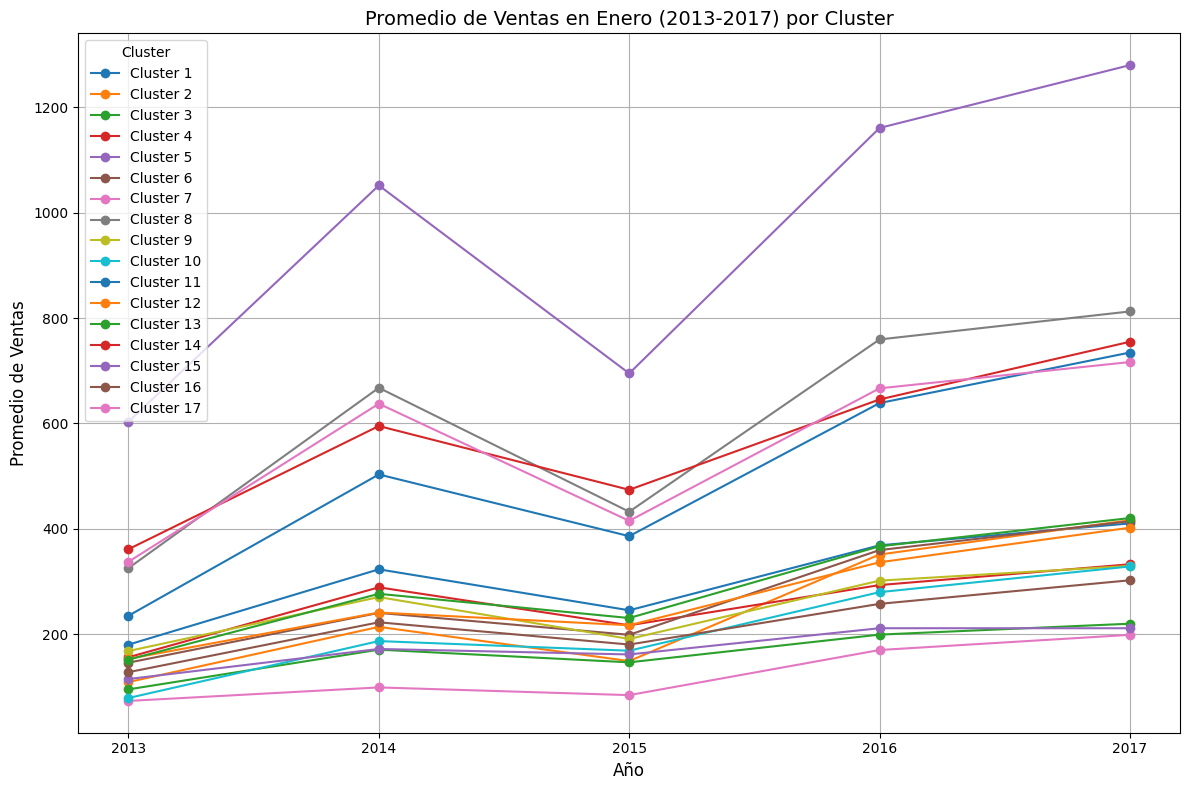

In [ ]:
import matplotlib.pyplot as plt

# Filtrar datos para el mes de enero
january_data = df_4[df_4['month'] == 1]

# Calcular el promedio de ventas por año y cluster
january_stats = january_data.groupby(['cluster', 'year'])['sales'].mean().reset_index()

# Crear un gráfico de líneas para cada cluster
plt.figure(figsize=(12, 8))

# Iterar sobre cada cluster y graficar su promedio de ventas a través de los años
clusters = january_stats['cluster'].unique()
for cluster in clusters:
    cluster_data = january_stats[january_stats['cluster'] == cluster]
    plt.plot(cluster_data['year'], cluster_data['sales'], marker='o', label=f'Cluster {cluster}')

# Configuración del gráfico
plt.title('Promedio de Ventas en Enero (2013-2017) por Cluster', fontsize=14)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Promedio de Ventas', fontsize=12)
plt.xticks(cluster_data['year'].unique())  # Etiquetas del eje X para años específicos
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()



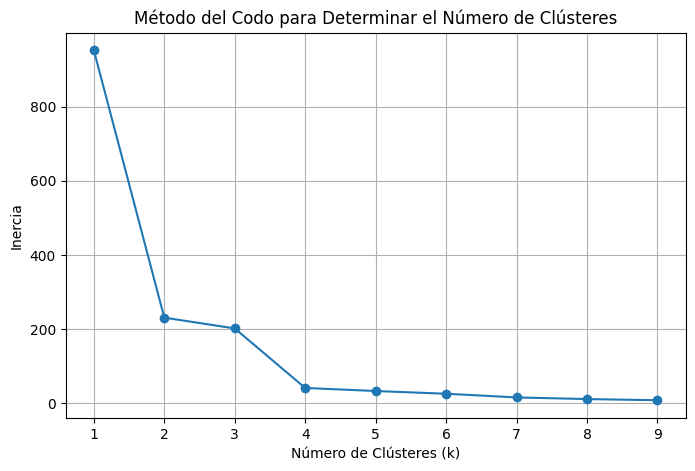

In [ ]:
#
from sklearn.cluster import KMeans

all_months_stats = df_4.groupby(['cluster', 'month', 'year'])['sales'].mean().reset_index()

# Crear una tabla pivote para comparar la media de ventas por cluster y mes en todos los años
pivot_table = all_months_stats.pivot_table(
    index='cluster',
    columns=['month', 'year'],
    values='sales',
    aggfunc='mean'
)

data = pivot_table.fillna(0)  # Llenar valores nulos con 0 para evitar problemas

# Escalar los datos
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# 2. Determinar el número óptimo de clústeres con el método del codo
inertia = []
k_range = range(1, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Método del Codo para Determinar el Número de Clústeres')
plt.xlabel('Número de Clústeres (k)')
plt.ylabel('Inercia')
plt.grid(True)
plt.show()

In [ ]:
# Continua mi codigo

Parte de Francis

In [ ]:
# Asegúrese de que la columna 'fecha' sea del tipo fecha y hora
df_4['date'] = pd.to_datetime(df_4['date'])

In [ ]:
# Conversión de fechas a componentes temporales
df_4['date'] = pd.to_datetime(df_4['date'])
df_4['year'] = df_4['date'].dt.year
df_4['month'] = df_4['date'].dt.month
df_4['day'] = df_4['date'].dt.day
df_4['day_of_week'] = df_4['date'].dt.dayofweek


In [ ]:
df_4.head()

,id,date,family,sales,Num_articulos_promocion,cluster,precio_oil,Tipo_de_Dia_No laborable Local,Tipo_de_Dia_No laborable National,Tipo_de_Dia_No laborable Regional,year,month,day,day_of_week
1782,1782,2013-01-02,AUTOMOTIVE,2.0,0,13,93.14,0,0,0,2013,1,2,2
1783,1783,2013-01-02,BABY CARE,0.0,0,13,93.14,0,0,0,2013,1,2,2
1784,1784,2013-01-02,BEAUTY,2.0,0,13,93.14,0,0,0,2013,1,2,2
1785,1785,2013-01-02,BEVERAGES,1091.0,0,13,93.14,0,0,0,2013,1,2,2
1786,1786,2013-01-02,BOOKS,0.0,0,13,93.14,0,0,0,2013,1,2,2


In [ ]:
# Codificación de variables categóricas
label_encoders = {}
for col in ['cluster', 'family']:  # Columnas categóricas
    le = LabelEncoder()
    df_4[col] = le.fit_transform(df_4[col])
    label_encoders[col] = le

In [ ]:
# Selección de variables predictoras y la variable objetivo
y = df_4['sales']
X = df_4.drop(columns=['id', 'date', 'sales'])

# División del dataset en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalización de los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Modelo 1: Regresión Lineal
print("\nEntrenando el modelo de Regresión Lineal...")
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)


Entrenando el modelo de Regresión Lineal...


LinearRegression()

In [ ]:
# Predicciones y evaluación de la Regresión Lineal
y_pred_reg = reg_model.predict(X_test)
print("\nMétricas de rendimiento para la Regresión Lineal:")
mse_reg = mean_squared_error(y_test, y_pred_reg)
rmse_reg = np.sqrt(mse_reg)
r2_reg = r2_score(y_test, y_pred_reg)
print(f'MSE: {mse_reg}, RMSE: {rmse_reg}, R2: {r2_reg}')


Métricas de rendimiento para la Regresión Lineal:
MSE: 718647.9965774243, RMSE: 847.7310874194861, R2: 0.21848202014117835


In [ ]:
# Modelo 2: Red Neuronal (MLP Regressor)
print("\nEntrenando la Red Neuronal...")
nn_model = MLPRegressor(hidden_layer_sizes=(64, 32, 16), max_iter=500, learning_rate_init=0.01, random_state=42)
nn_model.fit(X_train, y_train)


Entrenando la Red Neuronal...


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:697: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLPRegressor(hidden_layer_sizes=(64, 32, 16), learning_rate_init=0.01,
             max_iter=500, random_state=42)

In [ ]:
# Predicciones y evaluación de la Red Neuronal
y_pred_nn = nn_model.predict(X_test)
print("\nMétricas de rendimiento para la Red Neuronal:")
mse_nn = mean_squared_error(y_test, y_pred_nn)
rmse_nn = np.sqrt(mse_nn)
r2_nn = r2_score(y_test, y_pred_nn)
print(f'MSE: {mse_nn}, RMSE: {rmse_nn}, R2: {r2_nn}')


Métricas de rendimiento para la Red Neuronal:
MSE: 161571.6352559146, RMSE: 401.9597433275061, R2: 0.8242934808291993


In [ ]:
# Comparación de resultados
print("\nComparación de los modelos:")
print(f"Regresión Lineal - MSE: {mse_reg}, RMSE: {rmse_reg}, R2: {r2_reg}")
print(f"Red Neuronal - MSE: {mse_nn}, RMSE: {rmse_nn}, R2: {r2_nn}")



Comparación de los modelos:
Regresión Lineal - MSE: 718647.9965774243, RMSE: 847.7310874194861, R2: 0.21848202014117835
Red Neuronal - MSE: 161571.6352559146, RMSE: 401.9597433275061, R2: 0.8242934808291993


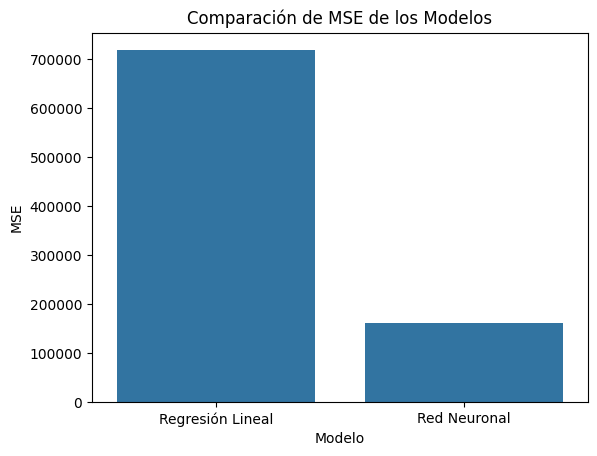

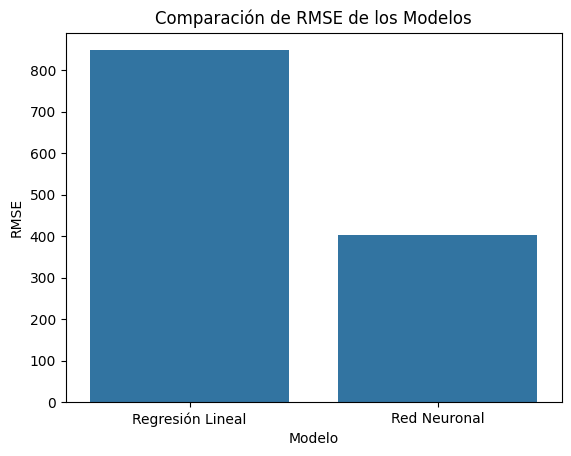

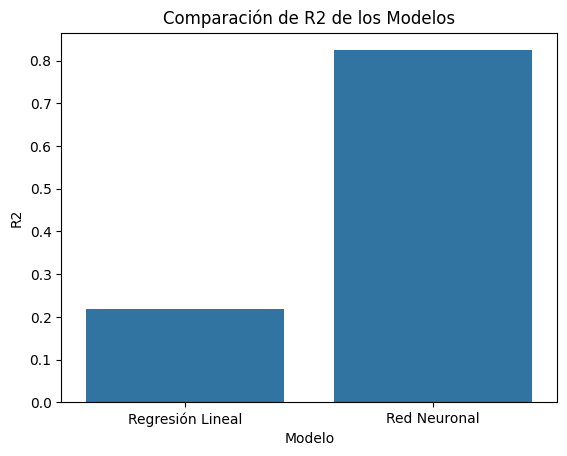

In [ ]:
# Visualización de los errores
errores = {'Modelo': ['Regresión Lineal', 'Red Neuronal'], 'MSE': [mse_reg, mse_nn], 'RMSE': [rmse_reg, rmse_nn], 'R2': [r2_reg, r2_nn]}
error_df = pd.DataFrame(errores)

sns.barplot(x='Modelo', y='MSE', data=error_df)
plt.title('Comparación de MSE de los Modelos')
plt.show()

sns.barplot(x='Modelo', y='RMSE', data=error_df)
plt.title('Comparación de RMSE de los Modelos')
plt.show()

sns.barplot(x='Modelo', y='R2', data=error_df)
plt.title('Comparación de R2 de los Modelos')
plt.show()

In [ ]:
# Reflexión sobre los modelos
if r2_nn > r2_reg:
    print("\nLa Red Neuronal muestra un mejor rendimiento predictivo en términos de R2.")
else:
    print("\nEl modelo de Regresión Lineal muestra un mejor rendimiento predictivo en términos de R2.")



La Red Neuronal muestra un mejor rendimiento predictivo en términos de R2.



Entrenando el modelo de Regresión Lineal...

Métricas de rendimiento para la Regresión Lineal:
MSE: 1000842.4286227606, RMSE: 1000.4211256379788, R2: 0.19469513250493475

Entrenando la Red Neuronal...

Métricas de rendimiento para la Red Neuronal:
MSE: 188365.44791522247, RMSE: 434.01088455846644, R2: 0.84843606971903

Comparación de los modelos:
Regresión Lineal - MSE: 1000842.4286227606, RMSE: 1000.4211256379788, R2: 0.19469513250493475
Red Neuronal - MSE: 188365.44791522247, RMSE: 434.01088455846644, R2: 0.84843606971903

La Red Neuronal muestra un mejor rendimiento predictivo en términos de R2.